In [6]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import keras 
from keras import layers,models
from keras import backend as K

In [7]:
def helper_print_with_time(*arg,sep=','):
    print(time.strftime("%H:%M:%S",time.localtime()),sep.join(map(str,arg)))

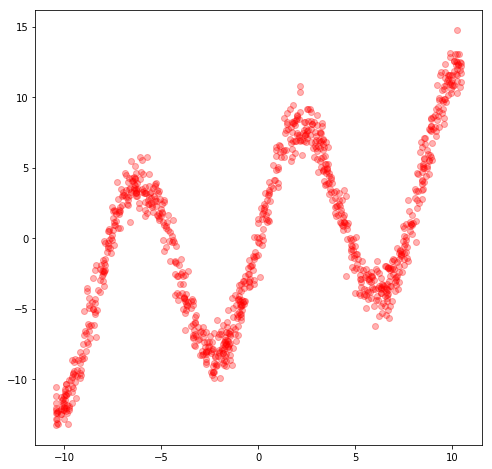

In [8]:
NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

In [9]:
helper_print_with_time('>>>begin')
model=models.Sequential()
model.add(layers.Dense(20,activation='tanh',input_shape=(1,)))
model.add(layers.Dense(1,activation='linear'))
model.compile(optimizer='rmsprop',loss='mse',metrics=['mse'])
model.fit(x_data,y_data,epochs=10000,batch_size=NSAMPLE,verbose=0)
helper_print_with_time('>>>end')

15:03:50 >>>begin
15:04:00 >>>end


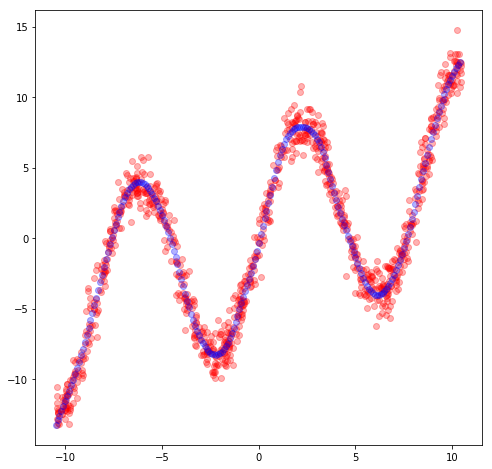

In [10]:
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test=model.predict(x_test)
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

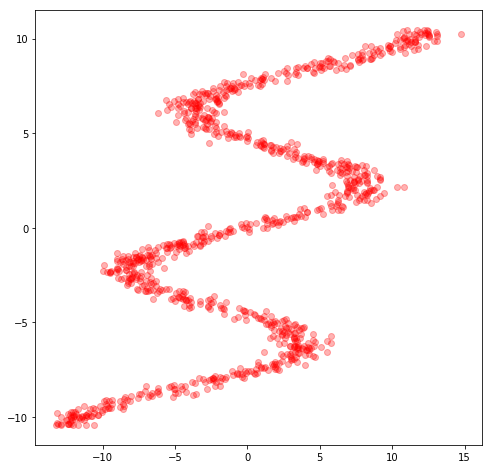

In [11]:
temp_data = x_data
x_data = y_data
y_data = temp_data

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

In [13]:
helper_print_with_time('>>>begin')
model.compile(optimizer='rmsprop',loss='mse',metrics=['mse'])
model.fit(x_data,y_data,epochs=10000,batch_size=NSAMPLE,verbose=0)
helper_print_with_time('>>>end')

15:05:24 >>>begin
15:05:34 >>>end


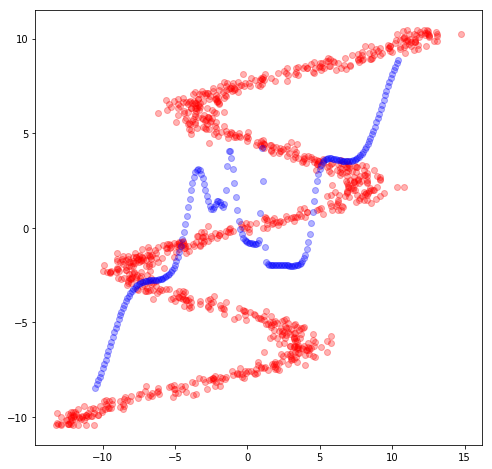

In [14]:
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test=model.predict(x_test)
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

# MDN

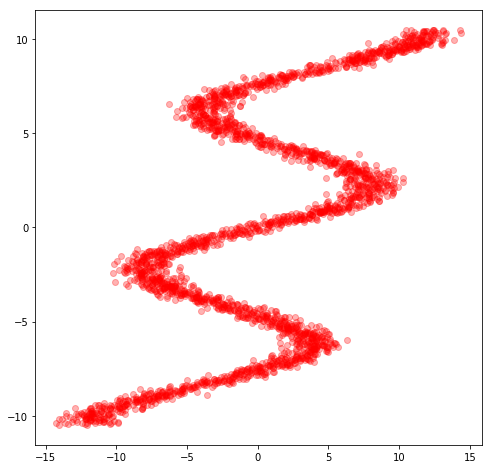

In [15]:
NSAMPLE = 2500

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

In [20]:
NHIDDEN = 128
KMIX = 24 # number of mixtures
NOUT = KMIX * 3 # pi, mu, stdev

Input = keras.Input(shape=(1,))
hidden=layers.Dense(NHIDDEN,activation='tanh')(Input)
op=layers.Dense(KMIX,activation='linear',name='op')(hidden)
op=layers.Softmax()(op)
ou=layers.Dense(KMIX,activation='linear',name='ou')(hidden)
os=layers.Dense(KMIX,activation='linear',name='os')(hidden)
Output=layers.Concatenate()([op,ou,os])
model=keras.Model(Input,Output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          256         input_2[0][0]                    
__________________________________________________________________________________________________
op (Dense)                      (None, 24)           3096        dense_6[0][0]                    
__________________________________________________________________________________________________
softmax_2 (Softmax)             (None, 24)           0           op[0][0]                         
__________________________________________________________________________________________________
ou (Dense)

In [21]:
def get_mixture_coef(output):
    out_pi = output[:,:KMIX]
    out_mu = output[:,KMIX:2*KMIX]
    out_sigma = K.exp(output[:,2*KMIX:])
    return out_pi,out_mu,out_sigma
def tf_normal(y, mu, sigma):
    oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)
    result=y-mu
    result=result/sigma
    result=-K.square(result)/2
    result=K.exp(result)*oneDivSqrtTwoPI/sigma
    return result
def get_loss(out_pi, out_sigma, out_mu, y):
    result= tf_normal(y,out_mu,out_sigma)
    result=result*out_pi
    result=K.sum(result,axis=1)
    result=-K.log(result)
    return K.mean(result)
def loss_func(y_true,y_pred):
    out_pi,out_mu,out_sigma = get_mixture_coef(y_pred)
    result=get_loss(out_pi,out_sigma,out_mu,y_true)
    return result

In [22]:
helper_print_with_time('>>>begin')
model.compile(optimizer='adam',loss=loss_func,metrics=[loss_func])
history=model.fit(x_data,y_data,epochs=10000,batch_size=NSAMPLE,verbose=0)
helper_print_with_time('>>>end')

15:10:41 >>>begin
15:11:59 >>>end


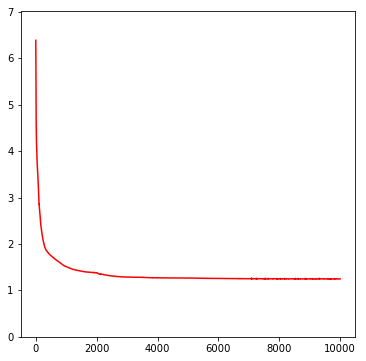

In [32]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], 'r-')
plt.ylim(0,max(history.history['loss'])*1.1)
plt.show()

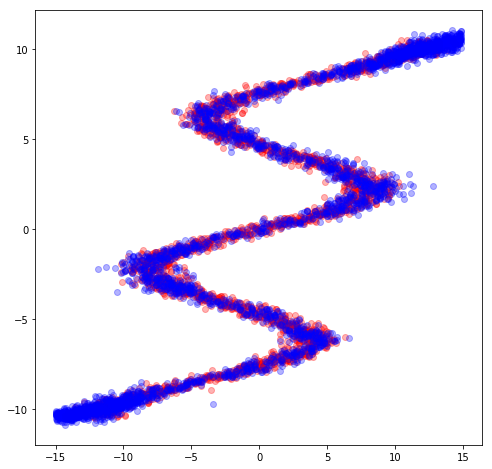

In [33]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print ('error with sampling ensemble')
    return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    mu = 0
    std = 0
    idx = 0

    # transforms result into random ensembles
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result

output=model.predict(x_test)
out_pi_test=output[:,:KMIX]
out_mu_test=output[:,KMIX:2*KMIX]
out_sigma_test=np.exp(output[:,KMIX*2:])

y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

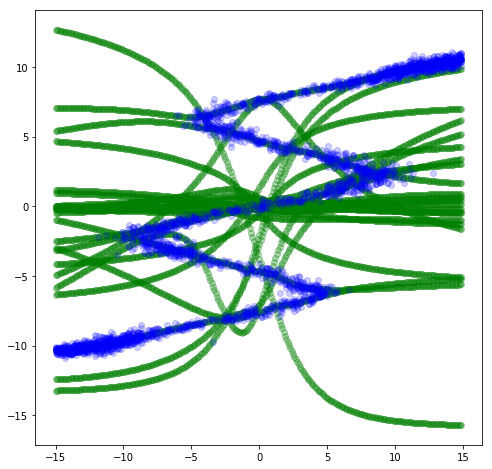

In [37]:
plt.figure(figsize=(8, 8))
plt.plot(x_test,out_mu_test,'go',alpha=0.3)
plt.plot(x_test,y_test,'bo',alpha=0.2)
plt.show()

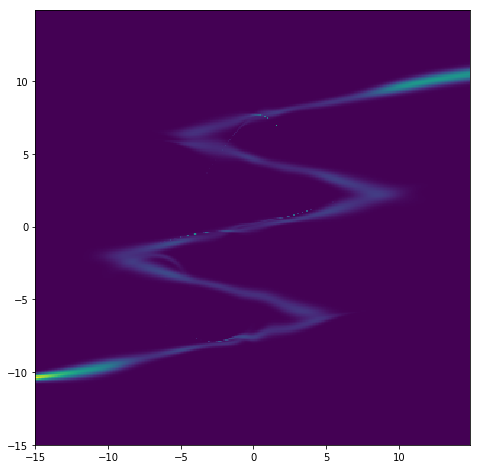

In [39]:
x_heatmap_label = np.float32(np.arange(-15,15,0.1))
y_heatmap_label = np.float32(np.arange(-15,15,0.1))
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)

def custom_gaussian(x, mu, std):
    x_norm = (x-mu)/std
    result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2)/std
    return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
    N = x_heatmap_label.size
    M = y_heatmap_label.size
    K = KMIX

    z = np.zeros((N, M)) # initially random [0, 1]

    mu = 0
    std = 0
    pi = 0

  # transforms result into random ensembles
    for k in range(0, K):
        for i in range(0, M):
            pi = out_pi[i, k]
            mu = out_mu[i, k]
            std = out_sigma[i, k]
            for j in range(0, N):
                z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)
    return z

def draw_heatmap(xedges, yedges, heatmap):
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap, extent=extent)
    plt.show()

z = generate_heatmap(out_pi_test, out_mu_test, out_sigma_test, x_heatmap_label, y_heatmap_label)
draw_heatmap(x_heatmap_label, y_heatmap_label, z)